# Randomized Min-Cut algorithm

## Node based contraction

### 1. Data Loading

In [1]:
install.packages("igraph")
library(igraph)

df<-read.table("karate_matrix.txt",stringsAsFactors=FALSE)


  There is a binary version available but the source version is later:
       binary source needs_compilation
igraph  1.2.6 1.2.10              TRUE

  Binaries will be installed
package 'igraph' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\key10\AppData\Local\Temp\RtmpULAhbq\downloaded_packages


Warning message:
"package 'igraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [2]:
head(df,3) 

V1,V2
"(2,1)",1
"(3,1)",1
"(4,1)",1


In [3]:
a1<-substr(df$V1,2,3)
a2<-substr(df$V1,4,6)
df2<-data.frame(a1,a2)

for(i in 1:2){
  df2[,i]<-sapply(df2[,i],function(x)gsub(",","",x))
  df2[,i]<-sapply(df2[,i],function(x)gsub(")","",x))
  df2[,i]<-as.numeric(df2[,i])                
}
head(df2,3) #complete Edge List of Graph

a1,a2
2,1
3,1
4,1


In [4]:
mat<-matrix(rep(0,34*34),34)

len<-length(df2$a1)
for(i in 1:len){
  j<-df2[i,1]
  k<-df2[i,2]
  mat[j,k]<-1
} 
head(mat,3) #complete adjacency matrix of Graph

0,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,1,0,0,0,1,1,1,...,0,0,0,1,1,0,0,0,1,0


In [5]:
karate_g<-graph_from_adjacency_matrix(mat,mode="undirected") 
karate_g #make graph object

IGRAPH 19b73e1 U--- 34 78 -- 
+ edges from 19b73e1:
 [1]  1-- 2  1-- 3  1-- 4  1-- 5  1-- 6  1-- 7  1-- 8  1-- 9  1--11  1--12
[11]  1--13  1--14  1--18  1--20  1--22  1--32  2-- 3  2-- 4  2-- 8  2--14
[21]  2--18  2--20  2--22  2--31  3-- 4  3-- 8  3-- 9  3--10  3--14  3--28
[31]  3--29  3--33  4-- 8  4--13  4--14  5-- 7  5--11  6-- 7  6--11  6--17
[41]  7--17  9--31  9--33  9--34 10--34 14--34 15--33 15--34 16--33 16--34
[51] 19--33 19--34 20--34 21--33 21--34 23--33 23--34 24--26 24--28 24--30
[61] 24--33 24--34 25--26 25--28 25--32 26--32 27--30 27--34 28--34 29--32
[71] 29--34 30--33 30--34 31--33 31--34 32--33 32--34 33--34

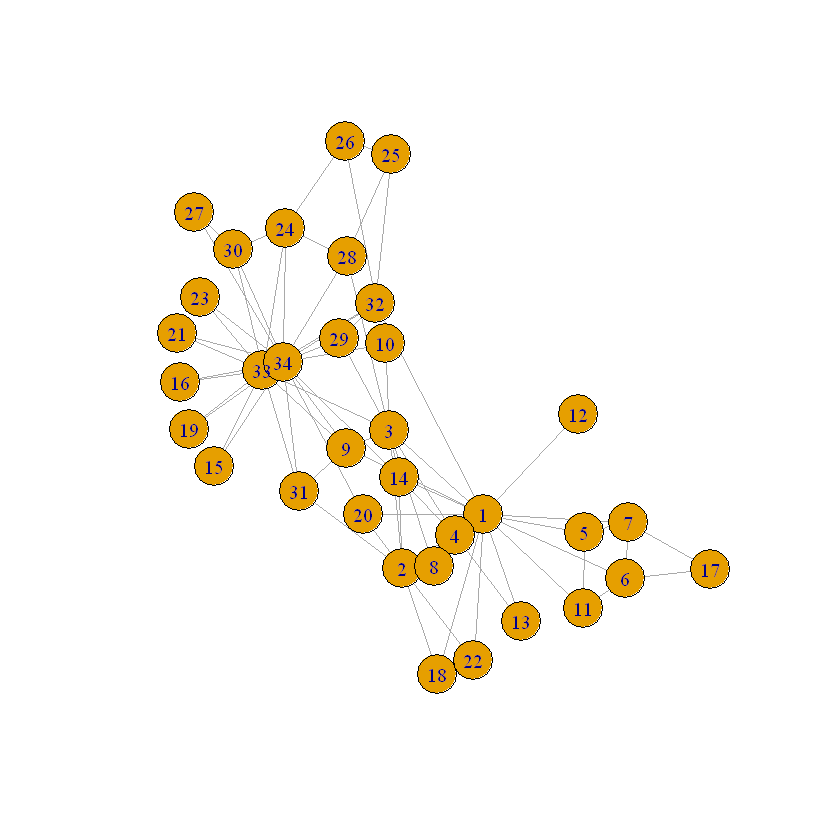

In [6]:
plot(karate_g)

### 2. Kargers Algorithm

In [7]:
matrix_mincut<-function(mat){
  top = dim(mat)[1]
  inds = 1:top
  while(length(inds)>2){
    pick = sample(inds,1)
    pick2 = sample(inds,1)
    
    while(pick==pick2){
      pick2 = sample(inds,1)
    }  ### select arbitrary two nodes (node based contraction) !!
    
    mat[,pick] = mat[,pick] + mat[,pick2]
    mat[pick,] = mat[pick,] + mat[pick2,]
    mat[pick,pick] = 0
    mat[pick2,]=0
    mat[,pick2]=0
    inds = inds[inds!=pick2]
  }
  return(max(mat))
}

kargers_mincut<-function(graph,mat_in,ep=1){
  n = length(V(graph))
  howmany = 1 #original
  #howmany = n^2*log(n)*ep #boosting
  mincut = Inf
  
  for(i in 1:howmany){
    mat = mat_in
    contender = matrix_mincut(mat)
    if(contender<mincut){
      mincut = contender
    }
  }
  return(mincut)
}

### 3. Karger Stein Algorithm

In [11]:
kargers_mincut_mat<-function(mat_in,n){
  # howmany = n^2*log(n)*100 #Don't want to have incorrect mincut when the number of vertices is small.
  howmany = 1 #just try once.
    mincut = Inf
  
  for(i in 1:howmany){
    mat = mat_in
    contender = matrix_mincut(mat)
    if(contender<mincut & contender !=0){
      mincut = contender
    }
  }
  return(mincut)
  
}


squish <- function(mat,inds,t){
  while(length(inds)>t){
    pick = sample(inds,1)
    pick2 = sample(inds,1)
    while(pick==pick2){
      pick2 = sample(inds,1)
    } ### select arbitrary two nodes (node based contraction) !!
    mat[,pick] = mat[,pick]+mat[,pick2]
    mat[pick,] = mat[pick,]+mat[pick2,]
    mat[pick,pick] = 0
    mat[pick2,] = 0
    mat[,pick2] = 0
    inds = inds[inds!=pick2]
  }
  p = list(mat,inds)
  return(p)
}

karger_stein_mincut<-function(matrix,inds){
  big = length(inds)
  if(big<=6){ #spare constraint not to fall in infinite loop.
    mincut = kargers_mincut_mat(matrix,2*big)
    return(mincut)
  }else{
    t = 1+big/sqrt(2)
    in1 = matrix
    in2 = matrix
    p1 = squish(in1,inds,t)
    p2 = squish(in2,inds,t)
    
    mat1 = p1[[1]]
    ind1 = p1[[2]]
    mat2 = p2[[1]]
    ind2 = p2[[2]]
    
    return(min(karger_stein_mincut(mat1,ind1),karger_stein_mincut(mat2,ind2)))
  }
}

ks_mincut<-function(graph,graph_mat){
  n = length(V(graph))
  top = 1 #original
  #top = (log(n))^2 #boosting
  mincut = Inf
  for(i in 1:top){
    inds = 1:n
    graph_mat2 = graph_mat
    maybe = karger_stein_mincut(graph_mat2, inds)
    if(maybe<mincut){
      mincut = maybe
    }
  }
  return(mincut)
}

### 4. Comparison

In [14]:
start=Sys.time()
kargers_mincut(karate_g,mat) #kargers algorithm
print(Sys.time()-start)

[1] 21

Time difference of 0.01978016 secs


In [31]:
start=Sys.time()
ks_mincut(karate_g,mat) #karger stein algorithm
print(Sys.time()-start)

[1] 2

Time difference of 0.042871 secs


### 5. Boosting to make the probability of success more than 1-1/n (=0.97).

In [35]:
matrix_mincut<-function(mat){
  top = dim(mat)[1]
  inds = 1:top
  while(length(inds)>2){
    pick = sample(inds,1)
    pick2 = sample(inds,1)
    
    while(pick==pick2){
      pick2 = sample(inds,1)
    }
    
    mat[,pick] = mat[,pick] + mat[,pick2]
    mat[pick,] = mat[pick,] + mat[pick2,]
    mat[pick,pick] = 0
    mat[pick2,]=0
    mat[,pick2]=0
    inds = inds[inds!=pick2]
  }
  return(max(mat))
}

kargers_mincut<-function(graph,mat_in,ep=1){
  n = length(V(graph))
  #howmany = 1 #original
  howmany = n^2*log(n)*ep #boosting
  mincut = Inf
  
  for(i in 1:howmany){
    mat = mat_in
    contender = matrix_mincut(mat)
    if(contender<mincut){
      mincut = contender
    }
  }
  return(mincut)
}

start=Sys.time()
kargers_mincut(karate_g,mat) #kargers method(boosting) 
print(Sys.time()-start)

[1] 1

Time difference of 2.636001 secs


In [36]:
kargers_mincut_mat<-function(mat_in,n){
  # howmany = n^2*log(n)*100 #Don't want to have incorrect mincut when the number of vertices is small.
  howmany = 1 #just try once.
    mincut = Inf
  
  for(i in 1:howmany){
    mat = mat_in
    contender = matrix_mincut(mat)
    if(contender<mincut & contender !=0){
      mincut = contender
    }
  }
  return(mincut)
  
}


squish <- function(mat,inds,t){
  while(length(inds)>t){
    pick = sample(inds,1)
    pick2 = sample(inds,1)
    while(pick==pick2){
      pick2 = sample(inds,1)
    }
    mat[,pick] = mat[,pick]+mat[,pick2]
    mat[pick,] = mat[pick,]+mat[pick2,]
    mat[pick,pick] = 0
    mat[pick2,] = 0
    mat[,pick2] = 0
    inds = inds[inds!=pick2]
  }
  p = list(mat,inds)
  return(p)
}

karger_stein_mincut<-function(matrix,inds){
  big = length(inds)
  if(big<=6){ #spare constraint
    mincut = kargers_mincut_mat(matrix,2*big)
    return(mincut)
  }else{
    t = 1+big/sqrt(2)
    in1 = matrix
    in2 = matrix
    p1 = squish(in1,inds,t)
    p2 = squish(in2,inds,t)
    
    mat1 = p1[[1]]
    ind1 = p1[[2]]
    mat2 = p2[[1]]
    ind2 = p2[[2]]
    
    return(min(karger_stein_mincut(mat1,ind1),karger_stein_mincut(mat2,ind2)))
  }
}

ks_mincut<-function(graph,graph_mat){
  n = length(V(graph))
  #top = 1 #original
  top = (log(n))^2 #boosting
  mincut = Inf
  for(i in 1:top){
    inds = 1:n
    graph_mat2 = graph_mat
    maybe = karger_stein_mincut(graph_mat2, inds)
    if(maybe<mincut){
      mincut = maybe
    }
  }
  return(mincut)
}

start=Sys.time()
ks_mincut(karate_g,mat) #karger stein method(boosting) 
print(Sys.time()-start)

[1] 1

Time difference of 0.657701 secs
